# Step 3: Establish a Connection to OANDA


In [4]:
import v20
import pandas as pd
import numpy as np
import json
from oandapyV20 import API
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
api = v20.Context(
    hostname='api-fxpractice.oanda.com',
    port=443,
    ssl=True,
    token='f6e0e0226d7c8c6c885277f1603f38fb-7d09224ecbaaa0db1636036429cf781a',
    datetime_format='RFC3339'
)
access_token='f6e0e0226d7c8c6c885277f1603f38fb-7d09224ecbaaa0db1636036429cf781a'

# Step 4: Fetch Historical Data


In [5]:


# Step 4: Fetch Historical Data
def fetch_forex_data(from_date, to_date, granularity, instrument):
    client = API(access_token=access_token, environment="practice")
    params = {
        "granularity": granularity,
        "from": from_date,
        "to": to_date
    }
    data = []
    try:
        for request in InstrumentsCandlesFactory(instrument=instrument, params=params):
            response = client.request(request)
            if response:
                for candle in response.get('candles'):
                    rec = {
                        'time': candle.get('time')[0:19],
                        'complete': candle['complete'],
                        'open': float(candle['mid']['o']),
                        'high': float(candle['mid']['h']),
                        'low': float(candle['mid']['l']),
                        'close': float(candle['mid']['c']),
                        'volume': candle['volume'],
                    }
                    data.append(rec)
    except Exception as e:
        print(f"An error occurred fetching data: {e}")
    return pd.DataFrame(data)

prices = fetch_forex_data('2012-01-01T00:00:00Z', '2018-02-18T00:00:00Z', 'M15', 'EUR_USD')


In [6]:
prices.to_csv('EURUSD_M15.csv', index=False)

# Step 5: Define and Test a Simple Trading Strategy


In [7]:
def simple_moving_average_strategy(df):
    df['SMA20'] = df['close'].rolling(window=20).mean()
    df['SMA50'] = df['close'].rolling(window=50).mean()
    df['signal'] = 0
    df.loc[50:, 'signal'] = np.where(df['SMA20'][50:] > df['SMA50'][50:], 1, 0)
    df['position'] = df['signal'].diff()
    return df

df = simple_moving_average_strategy(prices)


# Step 6: Automate Trading


In [8]:
def execute_trades(df, symbol):
    last_row = df.iloc[-1]
    try:
        if last_row['position'] == 1:
            print("Signal to BUY!")
            api.order.market(accountID=account_id, instrument=symbol, units=100)
        elif last_row['position'] == -1:
            print("Signal to SELL!")
            api.order.market(accountID=account_id, instrument=symbol, units=-100)
    except Exception as e:
        print(f"Failed to execute trade: {e}")

execute_trades(df, 'EUR_USD')

# Step 7: Implement Risk Management


In [9]:
def place_order_with_risk_management(symbol, units, sl_distance, tp_distance):
    try:
        api.order.market(
            accountID=account_id,
            instrument=symbol,
            units=units,
            stopLossOnFill={
                'distance': str(sl_distance)
            },
            takeProfitOnFill={
                'distance': str(tp_distance)
            }
        )
    except Exception as e:
        print(f"Failed to place order with risk management: {e}")


## Backtesting

# Step 1: Setup Backtesting Environment


Ending Value: 9980.63
Sharpe Ratio: -1.4426077835111077
Drawdown: 2.73592242027577
Returns: -0.0019388784105469543
Win Rate: 36.34%
Total Pip Profit: 23580.90
Total Pip Loss: 23826.20


<IPython.core.display.Javascript object>

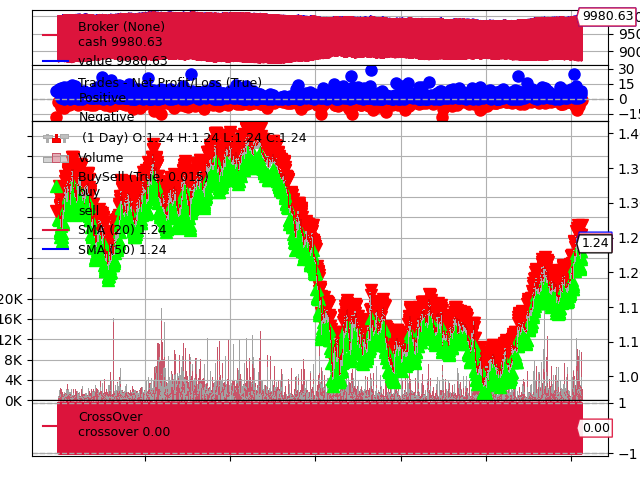

In [13]:
# Import necessary modules
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def calculate_metrics(trades):
    wins = 0
    total_pip_profit = 0
    total_pip_loss = 0
    
    for buy_price, sell_price in trades:
        pip_profit = (sell_price - buy_price) * 10000  # assuming EUR/USD pip size
        if pip_profit > 0:
            wins += 1
            total_pip_profit += pip_profit
        else:
            total_pip_loss += abs(pip_profit)
    
    win_rate = (wins / len(trades)) * 100 if trades else 0
    return win_rate, total_pip_profit, total_pip_loss
# Define the trading strategy
class SmaCross(bt.Strategy):
    params = (('sma1', 20), ('sma2', 50),)
    
    def __init__(self):
        sma1 = bt.ind.SMA(period=self.params.sma1)
        sma2 = bt.ind.SMA(period=self.params.sma2)
        self.crossover = bt.ind.CrossOver(sma1, sma2)
        self.order = None
        self.buyprice = None
        self.sellprice = None
        self.trades = []

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow upwards
                self.order = self.buy()
                self.buyprice = self.data.close[0]
        elif self.crossover < 0:  # in the market & fast crosses slow downwards
            self.sellprice = self.data.close[0]
            self.trades.append((self.buyprice, self.sellprice))
            self.order = self.sell()

    def stop(self):
        print(f'Ending Value: {self.broker.getvalue():.2f}')

# Load your data
data = pd.read_csv('EURUSD_M15.csv', parse_dates=True, index_col='time')

# Create a Backtrader data feed
data_feed = bt.feeds.PandasData(dataname=data)

# Set up the backtest
cerebro = bt.Cerebro()
cerebro.adddata(data_feed)
cerebro.addstrategy(SmaCross)
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)
cerebro.broker.set_cash(10000)  # Set initial cash

# Add analyzers for the performance metrics
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

# Run the backtest
results = cerebro.run()
strat = results[0]

# Print the analytics
print('Sharpe Ratio:', strat.analyzers.sharpe.get_analysis()['sharperatio'])
print('Drawdown:', strat.analyzers.drawdown.get_analysis()['max']['drawdown'])
print('Returns:', strat.analyzers.returns.get_analysis()['rtot'])

# Extract and analyze metrics
win_rate, total_pip_profit, total_pip_loss = calculate_metrics(strat.trades)
print(f"Win Rate: {win_rate:.2f}%")
print(f"Total Pip Profit: {total_pip_profit:.2f}")
print(f"Total Pip Loss: {total_pip_loss:.2f}")

# Plot the results
cerebro.plot(style='candlestick')
plt.savefig('backtest_results.png')  # Saves the current figure to a file named 'backtest_results.png'
plt.close()
from IPython.display import Image

# Display the image file in the Jupyter Notebook output cell
Image(filename='backtest_results.png')